## Statystyka i procesy stochastyczne, Ćw. proj., grupa 4 


* Wojciech Pełka
* Konrad Stalmach
* Filip Stolarczyk
* Hubert Sujka


In [16]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython.core.display import display
from scipy.optimize import curve_fit
from scipy.special import factorial
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
#funkcje pomocnicze
def take_n_split(string,delimiter,pos):
    s=string.split(delimiter)
    if s[pos][0]=='0':
        return int(s[pos][1])
    else:
        return int(s[pos])
def select_minute(data,minute):
    return data.loc[data['Minutes'] == minute]
def select_hour(data,hour):
    return data.loc[data['Hours'] == hour]


def select_time_data(data,n_samples,hour,minute):
    new_data=data.head(n_samples)
    new_data['Minutes']=new_data['Time'].apply(lambda x: take_n_split(x,':',2))
    new_data['Seconds']=new_data['Time'].apply(lambda x: take_n_split(x,':',3))
    new_data['Hours']=new_data['Time'].apply(lambda x: take_n_split(x,':',1))
    new_data['in_minute']=new_data['Minutes'].apply(lambda x: x==minute)
    new_data['in_hour']=new_data['Hours'].apply(lambda x: x==hour)
    
   
    
    data_out=new_data.loc[(new_data['in_minute'] == True) & (new_data['in_hour']==True)] 
    display(data_out)
    # new_data=new_data.loc[new_data['Hours'] == hour]
    # nr_events=len(new_data['Seconds'])
    
    return data_out, len(data_out)


,IP,Time,URL,Staus,Minutes,Seconds,Hours,in_minute,in_hour
15,10.129.2.1,[29/Nov/2017:13:38:03,POST /process.php HTTP/1.1,302,38,3,13,True,True
16,10.131.0.1,[29/Nov/2017:13:38:04,GET /home.php HTTP/1.1,200,38,4,13,True,True
17,10.131.0.1,[29/Nov/2017:13:38:07,GET /contestproblem.php?name=RUET%20OJ%20Serve...,200,38,7,13,True,True
18,10.130.2.1,[29/Nov/2017:13:38:19,GET / HTTP/1.1,302,38,19,13,True,True
19,10.131.2.1,[29/Nov/2017:13:38:20,GET /login.php HTTP/1.1,200,38,20,13,True,True
20,10.131.2.1,[29/Nov/2017:13:38:20,GET /css/bootstrap.min.css HTTP/1.1,200,38,20,13,True,True
21,10.128.2.1,[29/Nov/2017:13:38:20,GET /css/font-awesome.min.css HTTP/1.1,200,38,20,13,True,True
22,10.131.0.1,[29/Nov/2017:13:38:20,GET /css/normalize.css HTTP/1.1,200,38,20,13,True,True
23,10.128.2.1,[29/Nov/2017:13:38:20,GET /css/style.css HTTP/1.1,200,38,20,13,True,True
24,10.131.0.1,[29/Nov/2017:13:38:20,GET /js/vendor/modernizr-2.8.3.min.js HTTP/1.1,200,38,20,13,True,True


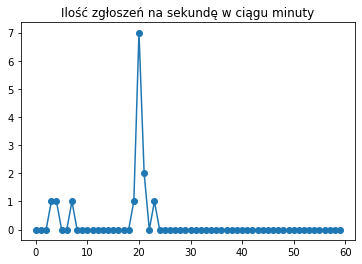

In [12]:
data=pd.read_csv('weblog.csv')

selected_minute_data,nr_events=select_time_data(data,50,13,38)
logs_per_second=[]
for i in range (60):
    in_minute=selected_minute_data.apply(lambda x: x['Seconds']==i,axis=1)
    n_logs=len(in_minute[in_minute==True].index)
    logs_per_second.append([i,n_logs])
    
    
ax=plt.figure()
plt.scatter(np.array(logs_per_second)[:,0],np.array(logs_per_second)[:,1])
plt.plot(np.array(logs_per_second)[:,0],np.array(logs_per_second)[:,1])
plt.title("Ilość zgłoszeń na sekundę w ciągu minuty")
plt.show()

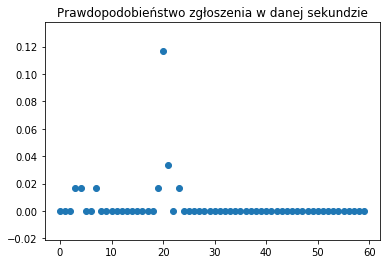

In [13]:
lps=np.array(logs_per_second)
prob_lps=[i/len(lps) for i in lps[:,1]]

fig=plt.figure()
plt.scatter(lps[:,0],prob_lps)
plt.title("Prawdopodobieństwo zgłoszenia w danej sekundzie")
plt.show()


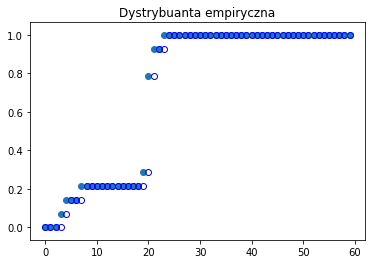

In [14]:
# dystrybuanta
distribution=[]
dist2=[0]
distribution.append(logs_per_second[0])
for i in range(1,len(logs_per_second)):

    distribution.append([i,distribution[i-1][1]+logs_per_second[i][1]/nr_events])
    dist2.append(distribution[i-1][1])
ax2=plt.figure()
dist=np.array(distribution)
#plt.plot(dist[:,0],dist[:,1])
plt.scatter(dist[:,0],dist[:,1])
d=np.array(dist2)

plt.plot(dist[:,0],d,'bo',mfc='none')
plt.title("Dystrybuanta empiryczna")
plt.show()


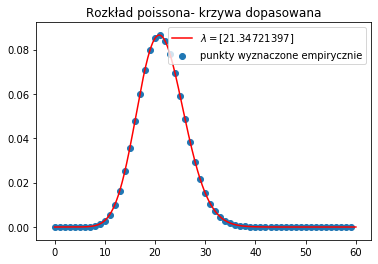

In [15]:
def poisson(k, lamb):
    return (lamb ** k / factorial(k)) * np.exp(-lamb)


# fit with curve_fit


parameters, cov_matrix = curve_fit(poisson, lps[:, 0], prob_lps)

ax = plt.gca(title='Rozkład poissona- krzywa dopasowana')
x = np.linspace(0, 60, 1000)

ax.plot(x, poisson(x, parameters),'r',label=f"$\lambda = {parameters}$")
ax.scatter(lps[:, 0], poisson(lps[:, 0], parameters),label='punkty wyznaczone empirycznie')

ax.legend()
plt.show()


**Wnioski:**
